# The model : Learning place cells, grid cells and invariances with excitatory and inhibitory plasticity 

Simon Nikolaus Weber, Henning Sprekeler

https://elifesciences.org/articles/34560


$$r^{out}(x(t)) =[ \sum^{Ne}_{i=1} w_i^{E}(t)r_i^{E}(x(t))-\sum^{Ni}_{j=1} w_j^{I}(t)r_j^{I}(x(t)) ]$$

$$\delta w^{E}= \eta_E r^{E}(x)r^{out}(x)$$

$$r_i^P(x)=\alpha_p exp\big({-\frac{(x-\mu_i)^2}{2\sigma_p^2}}\big)$$


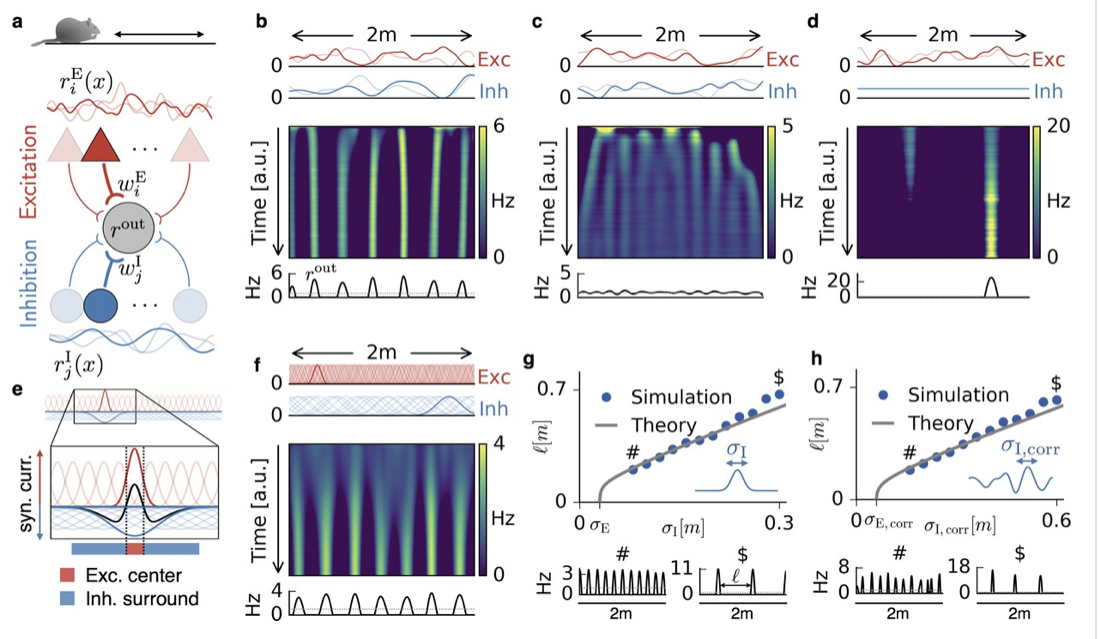

In [1]:
import sys
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sehec.arenas.simple2d import Simple2D, Sargolini2006, Hafting2008,BasicSargolini2006
from sehec.agents.weber_2018 import ExcInhPlasticity

In [2]:

from pathlib import Path
print(Path.cwd())

data_path = "../../sehec/experiments/sargolini_2006/"

env = BasicSargolini2006(data_path=data_path,time_step_size=0.1,
                                 agent_step_size=None)


        

/home/rodrigo/SSD/Projects/EHC_model_comparison/examples/agent_examples


100%|██████████| 4900/4900 [00:01<00:00, 3551.18it/s]


array([<AxesSubplot:title={'center':'Exc rates'}>,
       <AxesSubplot:title={'center':'Inh rates'}>,
       <AxesSubplot:title={'center':'Out rate'}>], dtype=object)

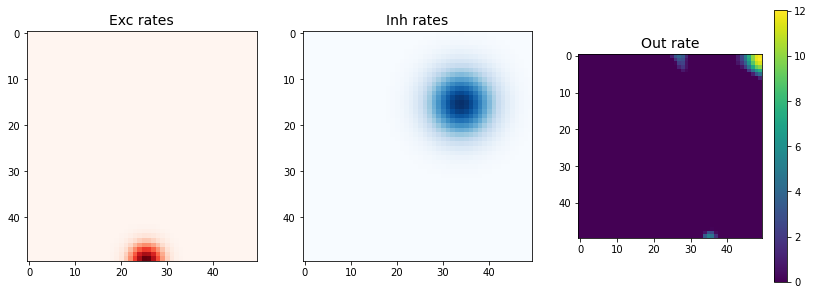

In [3]:
exc_eta = 2e-4
inh_eta = 8e-4
model_name = "model_example"
sigma_exc = np.array([0.05, 0.05])
sigma_inh = np.array([0.1, 0.1])
Ne = 4900
Ni = 1225
Nef = 1
Nif = 1
alpha_i = 1
alpha_e = 1
we_init = 1.0
wi_init = 1.5
agent_step_size = 0.1
    
agent = ExcInhPlasticity(model_name=model_name, exc_eta=exc_eta, inh_eta=inh_eta, sigma_exc=sigma_exc,
                                 sigma_inh=sigma_inh, Ne=Ne, Ni=Ni, agent_step_size=agent_step_size, ro=1,
                                 Nef=Nef, Nif=Nif, room_width=env.room_width, room_depth=env.room_depth,
                                 alpha_i=alpha_i, alpha_e=alpha_e, we_init=we_init, wi_init=wi_init)

agent.plot_rates()

100%|██████████| 1000/1000 [00:04<00:00, 249.14it/s]


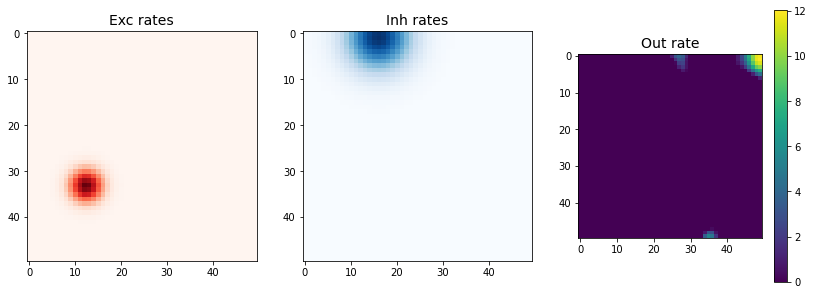

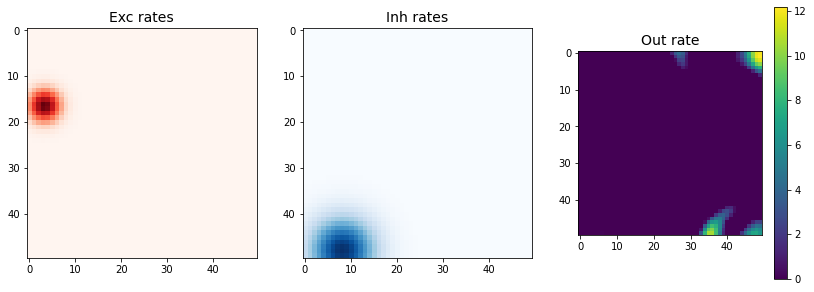

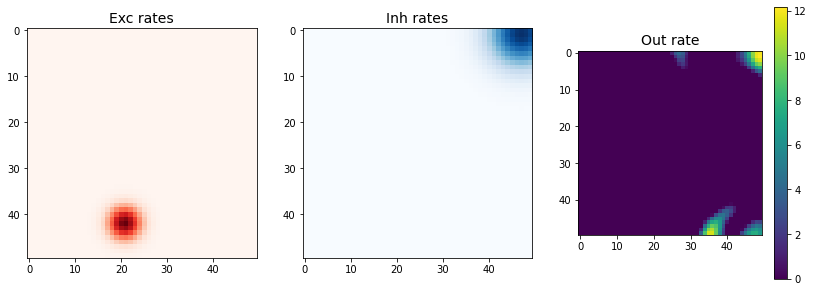

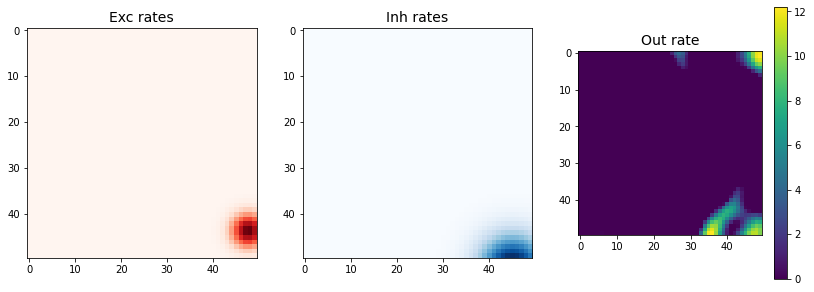

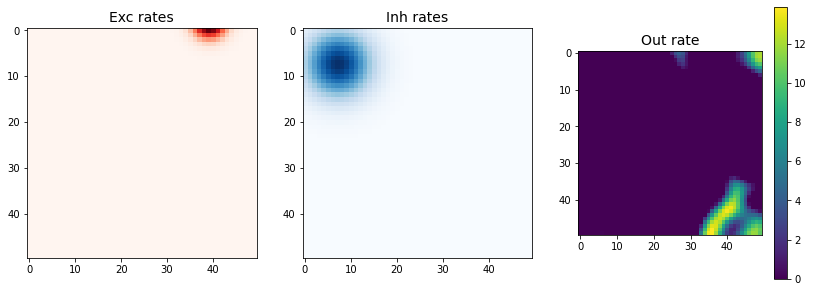

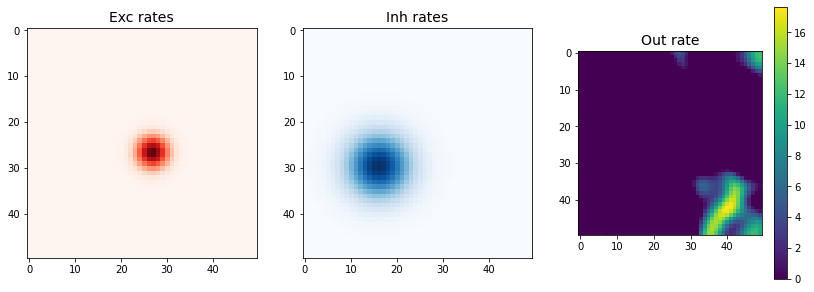

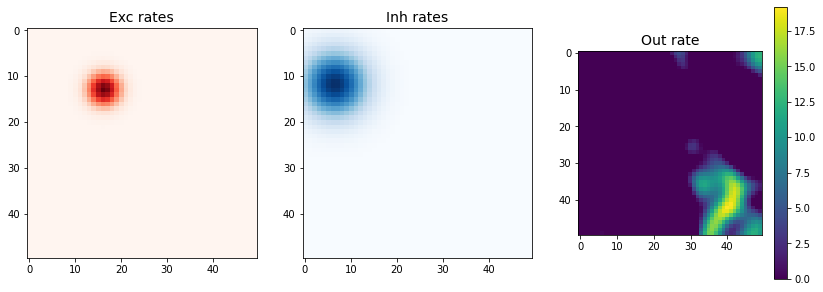

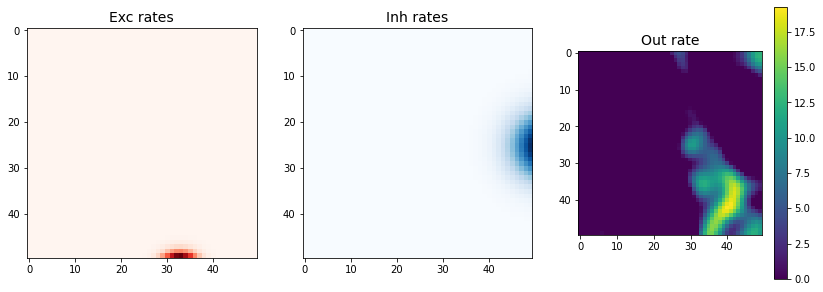

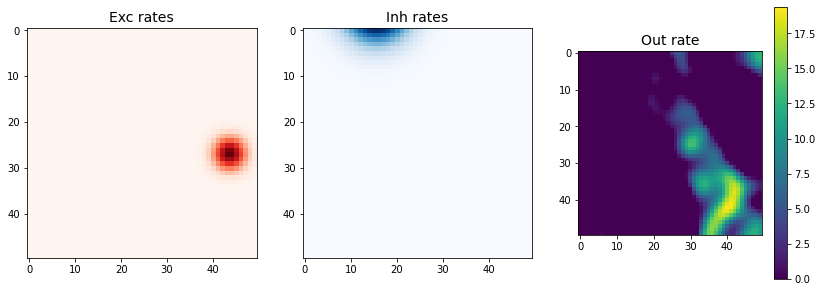

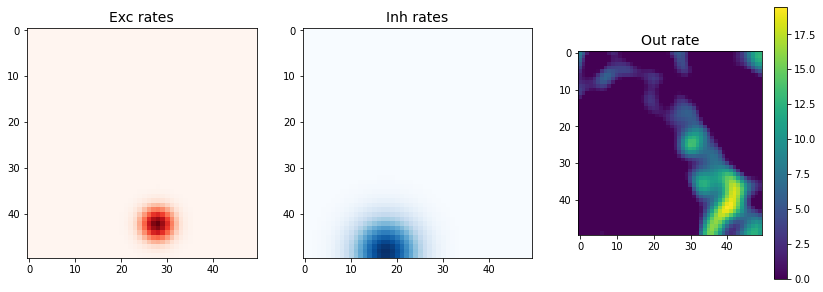

In [4]:
plot_every = 100
total_iters = 0
n_steps = 1000

obs, state = env.reset()
#for i in tqdm(range(env.total_number_of_steps)):
for i in tqdm(range(n_steps)):
    # Observe to choose an action
    obs = obs[:2]
    action = agent.act(obs)
    # rate = agent.update()
    agent.update()
    # Run environment for given action
    obs, state, reward = env.step(action)
    total_iters += 1
    if i % plot_every == 0:
         agent.plot_rates()
         
                

No handles with labels found to put in legend.


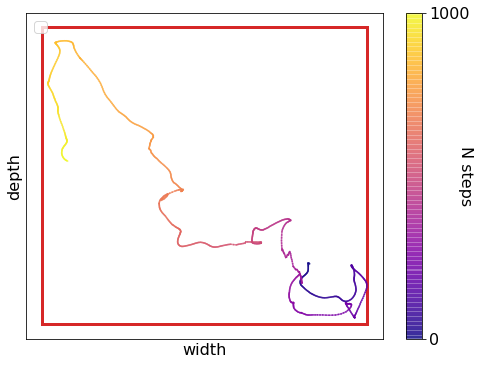

In [5]:
ax = env.plot_trajectory()
fontsize = 16
ax.grid()
ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)
plt.show()

In [6]:
# Create an env
room_width = [-10,10]
room_depth = [-10,10]
env_name = "env_example"
time_step_size = 1
agent_step_size = 0.5


# Init environment
envsimple = Simple2D(environment_name=env_name,
                     arena_x_limits = room_width,
                     arena_y_limits = room_depth,
                     time_step_size = time_step_size,
                     agent_step_size = agent_step_size)

In [7]:
exc_eta = 2e-4
inh_eta = 8e-4
model_name = "model_example"
sigma_exc = np.array([0.05, 0.05])
sigma_inh = np.array([0.1, 0.1])
Ne = 4900
Ni = 1225
Nef = 1
Nif = 1
alpha_i = 1
alpha_e = 1
we_init = 1.0
wi_init = 1.5
agent_step_size = 0.1
agentsimple = ExcInhPlasticity(model_name=model_name, exc_eta=exc_eta, inh_eta=inh_eta, sigma_exc=sigma_exc,
                                 sigma_inh=sigma_inh, Ne=Ne, Ni=Ni, agent_step_size=agent_step_size, ro=1,
                                 Nef=Nef, Nif=Nif, room_width=envsimple.room_width, room_depth=envsimple.room_depth,
                                 alpha_i=alpha_i, alpha_e=alpha_e, we_init=we_init, wi_init=wi_init)


100%|██████████| 4900/4900 [00:01<00:00, 3742.36it/s]


  0%|          | 9/50000 [00:00<09:24, 88.52it/s]

20


100%|██████████| 50000/50000 [03:26<00:00, 241.74it/s]


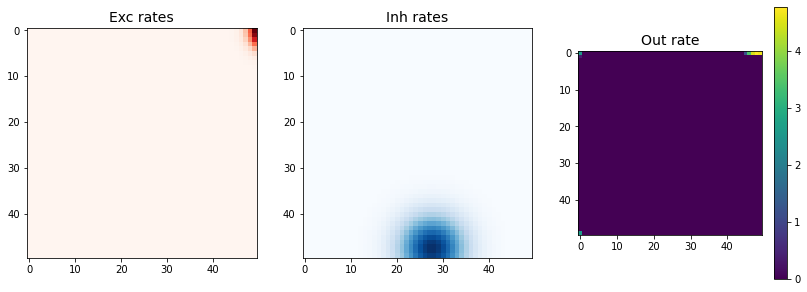

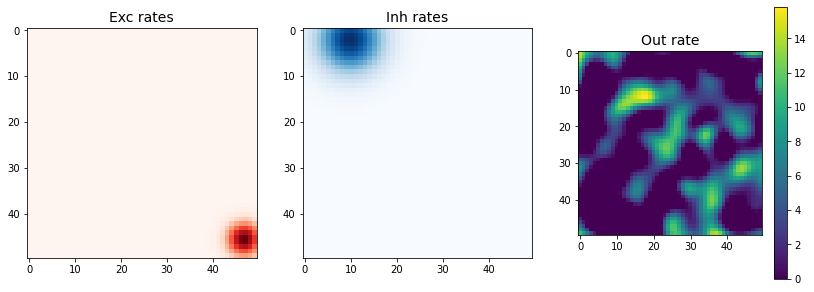

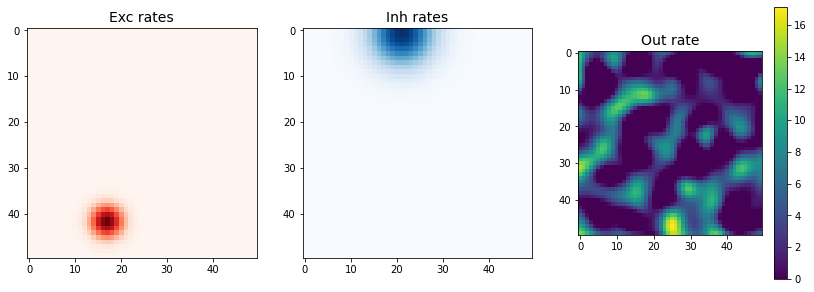

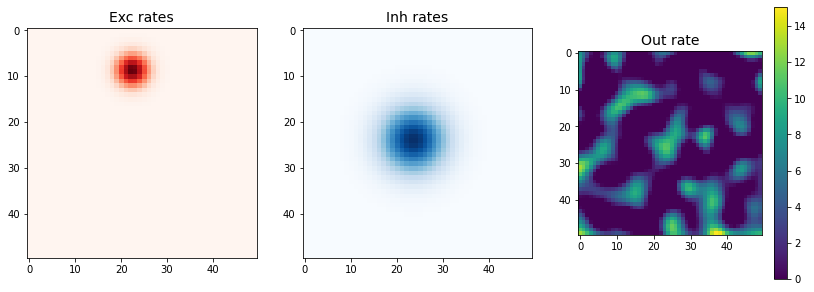

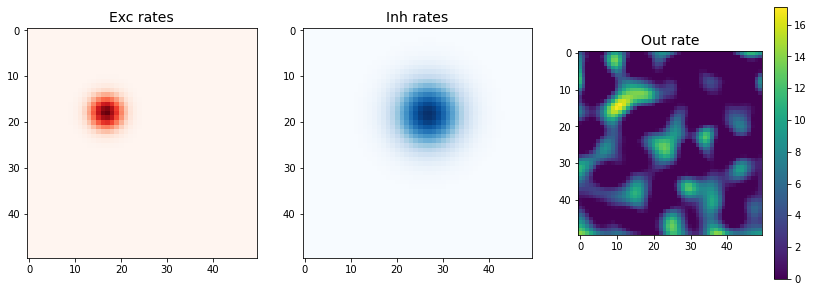

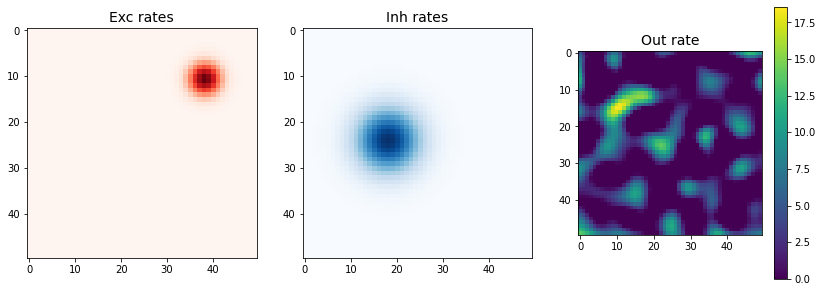

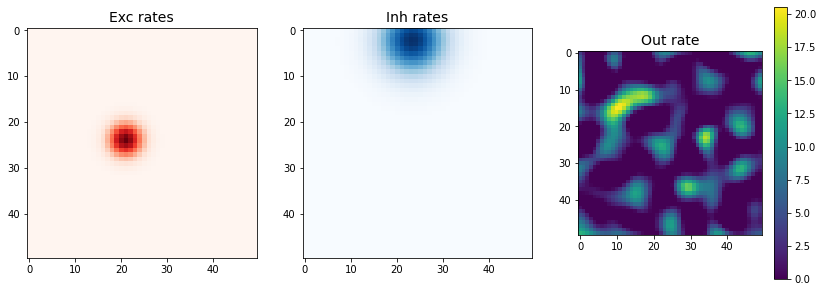

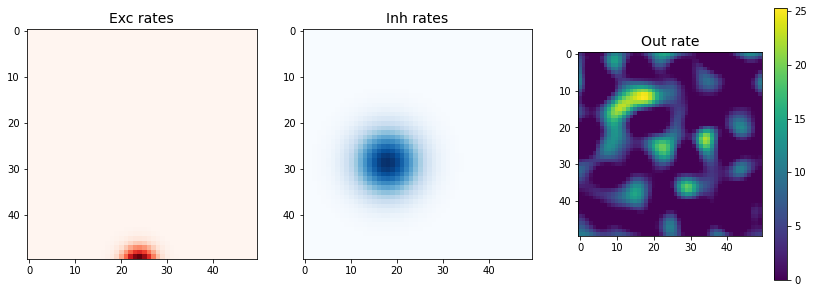

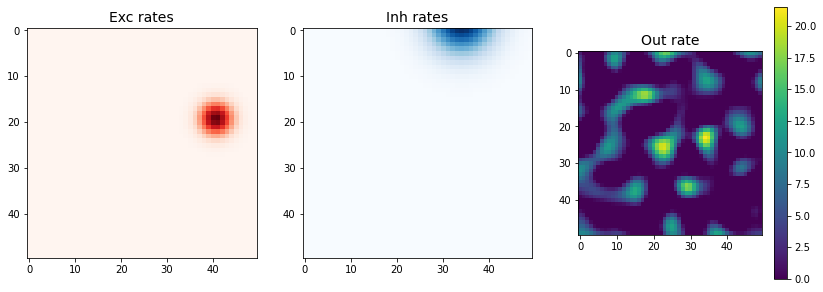

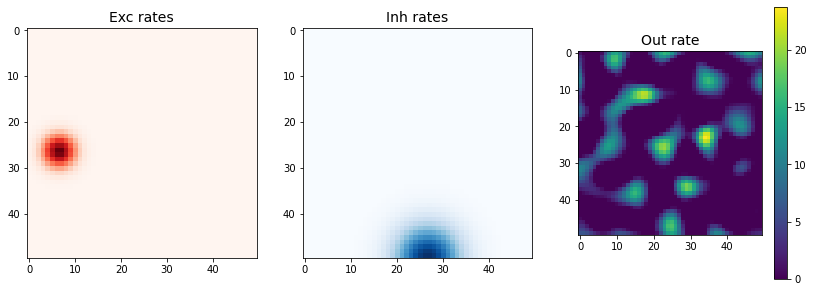

In [8]:
plot_every = 5000
total_iters = 0
n_steps = 50000
print(agentsimple.room_width)
obs, state = envsimple.reset()
for i in tqdm(range(n_steps)):
    # Observe to choose an action
    obs = obs[:2]
    action = agentsimple.act(obs)
    # rate = agent.update()
    agentsimple.update()
    # Run environment for given action
    obs, state, reward = envsimple.step(action)
    total_iters += 1
    if i % plot_every == 0:
        agentsimple.plot_rates()
        # agentsimple.plot_rates(save_path="pre_processed_iter_"+str(i)+".pdf")
                

No handles with labels found to put in legend.


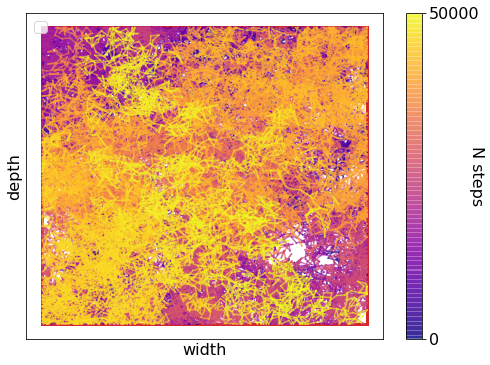

In [9]:
ax = envsimple.plot_trajectory()
fontsize = 16
ax.grid()
ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)
plt.show()